# Toy Example: CNN vs Wavelet Model for Signal Detection

**Goal:** Demonstrate that a physics-informed wavelet model outperforms a generic CNN for detecting signals hidden in noise.

- **Task:** Binary classification (noise vs signal+noise)
- **Signal:** Morlet wavelet embedded at random position
- **Key insight:** Inductive bias from matched filtering improves detection

## 1. Setup and Imports

In [1]:
# Standard libraries for numerical operations and visualization
import numpy as np
import matplotlib.pyplot as plt

# Metrics for model evaluation
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns

# PyTorch for deep learning
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split

In [2]:
# ============================================================
# CONFIGURATION
# ============================================================
epochs = 100          # Number of training epochs
fs = 256              # Sampling frequency (Hz)
duration = 10         # Signal duration (seconds)
seed = 42             # Random seed for reproducibility
device = torch.device('mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: mps


## 2. Signal Generation Functions

In [3]:
# ============================================================
# GAUSSIAN NOISE GENERATOR
# Creates random noise as our background signal
# ============================================================
def gaussian_noise(fs, duration, seed):
    """Generate Gaussian white noise."""
    np.random.seed(seed)
    t = np.linspace(0, duration, int(fs * duration), endpoint=False)
    noise = np.random.normal(0, 1, t.shape)
    return noise


# ============================================================
# MORLET WAVELET GENERATOR  
# Creates the target signal we want to detect
# ============================================================
def morlet_wavelet(duration, fs, f0, scale=1.0):
    """
    Generate a Morlet wavelet (oscillation modulated by Gaussian envelope).
    
    Parameters:
        duration: Length of wavelet (seconds)
        fs: Sampling frequency (Hz)
        f0: Central frequency (Hz)
        scale: Scale factor (controls width)
    """
    dt = 1.0 / fs
    M = int(duration * fs)
    t = (np.arange(M) - M // 2) * dt
    omega0 = 2 * np.pi * f0
    
    # Morlet wavelet: complex exponential × Gaussian envelope
    psi = np.exp(1j * omega0 * t / scale) * np.exp(-0.5 * (t / scale) ** 2)
    return psi

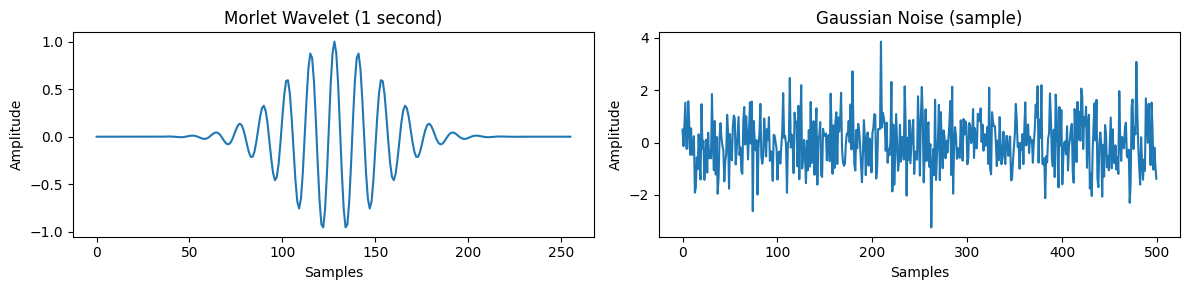

In [4]:
# Visualize the wavelet template and noise
wavelet = morlet_wavelet(duration=1.0, fs=256, f0=2, scale=0.1)
noise = gaussian_noise(fs, duration, seed)

fig, axes = plt.subplots(1, 2, figsize=(12, 3))

axes[0].plot(wavelet.real)
axes[0].set_title('Morlet Wavelet (1 second)')
axes[0].set_xlabel('Samples')
axes[0].set_ylabel('Amplitude')

axes[1].plot(noise[:500])
axes[1].set_title('Gaussian Noise (sample)')
axes[1].set_xlabel('Samples')
axes[1].set_ylabel('Amplitude')

plt.tight_layout()
plt.show()

## 3. Dataset Creation

In [5]:
# ============================================================
# DATASET CLASS
# Binary classification: noise (class 0) vs signal+noise (class 1)
# ============================================================
class WaveletNoiseDataset(Dataset):
    """
    Dataset for binary classification:
    - Class 0: Pure Gaussian noise
    - Class 1: Morlet wavelet hidden in Gaussian noise at random position
    """
    def __init__(self, n_samples, fs=256, duration=10, wavelet_duration=1.0, seed=42, snr=0.6):
        self.n_samples = n_samples
        self.data = []
        self.labels = []
        
        np.random.seed(seed)
        
        # Class 0: Pure noise samples
        for i in range(n_samples // 2):
            noise = gaussian_noise(fs, duration, seed + i)
            self.data.append(noise)
            self.labels.append(0)
        
        # Class 1: Wavelet embedded in noise at random position
        for i in range(n_samples // 2):
            noise = gaussian_noise(fs, duration, seed + n_samples + i)
            wavelet = morlet_wavelet(duration=wavelet_duration, fs=fs, f0=2, scale=0.1)
            wavelet_samples = len(wavelet.real)
            
            # Insert wavelet at random position
            max_start = int(fs * duration) - wavelet_samples
            np.random.seed(seed + n_samples + i + 1000)
            start_idx = np.random.randint(0, max_start)
            
            signal = noise.copy()
            signal[start_idx:start_idx + wavelet_samples] += snr * wavelet.real
            
            self.data.append(signal)
            self.labels.append(1)
        
        self.data = np.array(self.data, dtype=np.float32)
        self.labels = np.array(self.labels, dtype=np.int64)
    
    def __len__(self):
        return self.n_samples
    
    def __getitem__(self, idx):
        x = torch.from_numpy(self.data[idx]).unsqueeze(0)  # Add channel dim
        y = torch.tensor(self.labels[idx])
        return x, y


# ============================================================
# DATALOADER HELPER
# Splits data into train/val sets
# ============================================================
def create_dataloaders(n_samples, batch_size=32, train_split=0.8, fs=256, 
                       duration=10, wavelet_duration=1.0, snr=0.6, seed=42):
    """Create train and validation dataloaders."""
    dataset = WaveletNoiseDataset(n_samples, fs, duration, wavelet_duration, seed, snr)
    
    train_size = int(train_split * n_samples)
    val_size = n_samples - train_size
    
    train_dataset, val_dataset = random_split(
        dataset, [train_size, val_size],
        generator=torch.Generator().manual_seed(seed)
    )
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    return train_loader, val_loader

In [6]:
# Create the dataset
n_samples = 1000
batch_size = 32

train_loader, val_loader = create_dataloaders(
    n_samples=n_samples, batch_size=batch_size, snr=0.6, seed=42
)

print(f"Training samples: {len(train_loader.dataset)}")
print(f"Validation samples: {len(val_loader.dataset)}")

Training samples: 800
Validation samples: 200


## 4. Model Architectures

In [7]:
# ============================================================
# CNN MODEL (Baseline)
# Generic convolutional network - learns features from scratch
# ============================================================
class SimpleCNN(nn.Module):
    """Standard 1D CNN for time series classification."""
    def __init__(self, input_length=2560):
        super(SimpleCNN, self).__init__()
        
        # Convolutional layers: extract features
        self.conv_layers = nn.Sequential(
            nn.Conv1d(1, 16, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Conv1d(16, 32, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Conv1d(32, 64, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool1d(2),
        )
        
        # Fully connected layers: classification
        self.flat_size = 64 * (input_length // 8)
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(self.flat_size, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 2)  # Binary classification
        )
    
    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

In [8]:
# ============================================================
# WAVELET MODEL (Physics-Informed)
# Uses matched filtering with known wavelet template as inductive bias
# ============================================================
class WaveletModel(nn.Module):
    """
    Physics-informed model using matched filtering.
    The wavelet template provides strong inductive bias for detection.
    """
    def __init__(self, duration=1.0, fs=256, f0=2, scale=0.1):
        super(WaveletModel, self).__init__()
        
        # Store the known wavelet template (physics knowledge)
        wavelet = morlet_wavelet(duration=duration, fs=fs, f0=f0, scale=scale)
        self.template = wavelet.real
        
        # Small MLP to classify based on matched filter features
        self.mlp = nn.Sequential(
            nn.Linear(6, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 2)
        )
    
    def matched_filter(self, timeseries, template):
        """Perform matched filtering: correlate signal with template."""
        signal_tensor = torch.from_numpy(timeseries).float().unsqueeze(0).unsqueeze(0)
        template_tensor = torch.from_numpy(template).float().unsqueeze(0).unsqueeze(0)
        template_flipped = torch.flip(template_tensor, dims=[2])
        
        padding = len(template) // 2
        response = F.conv1d(signal_tensor, template_flipped, padding=padding)
        response = response.squeeze().numpy()[:len(timeseries)]
        
        # Normalize by template energy
        template_energy = np.sum(template**2)
        response = response / np.sqrt(template_energy)
        return response
    
    def forward(self, x):
        batch_size = x.shape[0]
        outputs = []
        
        for i in range(batch_size):
            timeseries = x[i, 0, :].detach().cpu().numpy()
            response = self.matched_filter(timeseries, self.template)
            
            # Extract features from matched filter response
            features = np.array([
                np.max(response),                              # Peak value
                (np.max(response) - np.mean(response)) / (np.std(response) + 1e-8),  # SNR
                np.max(response) - np.mean(np.sort(response)[-10:-1]),  # Peak prominence
                np.std(response),                              # Variability
                np.max(response) - np.min(response),           # Range
                np.mean(response)                              # Mean
            ], dtype=np.float32)
            
            outputs.append(torch.from_numpy(features).float())
        
        outputs = torch.stack(outputs).to(x.device)
        return self.mlp(outputs)

In [9]:
# Initialize both models
cnn_model = SimpleCNN(input_length=2560).to(device)
wavelet_model = WaveletModel(duration=1.0, fs=256, f0=2, scale=0.1).to(device)

print(f"CNN parameters: {sum(p.numel() for p in cnn_model.parameters()):,}")
print(f"Wavelet Model parameters: {sum(p.numel() for p in wavelet_model.parameters()):,}")

CNN parameters: 2,634,818
Wavelet Model parameters: 9,282


## 5. Training Functions

In [10]:
# ============================================================
# TRAINING AND VALIDATION FUNCTIONS
# ============================================================
def train_epoch(model, loader, criterion, optimizer, device):
    """Train for one epoch and return loss and accuracy."""
    model.train()
    total_loss, correct, total = 0, 0, 0
    
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        
        optimizer.zero_grad()
        outputs = model(x)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        _, predicted = outputs.max(1)
        total += y.size(0)
        correct += predicted.eq(y).sum().item()
    
    return total_loss / len(loader), 100. * correct / total


def validate(model, loader, criterion, device):
    """Evaluate model on validation set."""
    model.eval()
    total_loss, correct, total = 0, 0, 0
    
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            outputs = model(x)
            loss = criterion(outputs, y)
            
            total_loss += loss.item()
            _, predicted = outputs.max(1)
            total += y.size(0)
            correct += predicted.eq(y).sum().item()
    
    return total_loss / len(loader), 100. * correct / total

In [11]:
# ============================================================
# TRAIN BOTH MODELS
# ============================================================
criterion = nn.CrossEntropyLoss()
optimizer_cnn = optim.Adam(cnn_model.parameters(), lr=0.001)
optimizer_wavelet = optim.Adam(wavelet_model.parameters(), lr=0.001)

# Storage for training curves
train_losses_cnn, val_losses_cnn, val_accs_cnn = [], [], []
train_losses_wavelet, val_losses_wavelet, val_accs_wavelet = [], [], []

best_val_acc_cnn, best_state_cnn = 0.0, None
best_val_acc_wavelet, best_state_wavelet = 0.0, None

print("Training both models...")
print("=" * 60)

for epoch in range(epochs):
    # Train CNN
    train_loss_cnn, _ = train_epoch(cnn_model, train_loader, criterion, optimizer_cnn, device)
    val_loss_cnn, val_acc_cnn = validate(cnn_model, val_loader, criterion, device)
    train_losses_cnn.append(train_loss_cnn)
    val_losses_cnn.append(val_loss_cnn)
    val_accs_cnn.append(val_acc_cnn)
    if val_acc_cnn > best_val_acc_cnn:
        best_val_acc_cnn = val_acc_cnn
        best_state_cnn = cnn_model.state_dict().copy()
    
    # Train Wavelet Model
    train_loss_wav, _ = train_epoch(wavelet_model, train_loader, criterion, optimizer_wavelet, device)
    val_loss_wav, val_acc_wav = validate(wavelet_model, val_loader, criterion, device)
    train_losses_wavelet.append(train_loss_wav)
    val_losses_wavelet.append(val_loss_wav)
    val_accs_wavelet.append(val_acc_wav)
    if val_acc_wav > best_val_acc_wavelet:
        best_val_acc_wavelet = val_acc_wav
        best_state_wavelet = wavelet_model.state_dict().copy()
    
    if (epoch + 1) % 20 == 0:
        print(f"Epoch {epoch+1:3d} | CNN: {val_acc_cnn:.1f}% | Wavelet: {val_acc_wav:.1f}%")

# Restore best models
cnn_model.load_state_dict(best_state_cnn)
wavelet_model.load_state_dict(best_state_wavelet)

print("=" * 60)
print(f"Best CNN Accuracy: {best_val_acc_cnn:.2f}%")
print(f"Best Wavelet Accuracy: {best_val_acc_wavelet:.2f}%")

Training both models...
Epoch  20 | CNN: 50.5% | Wavelet: 64.0%
Epoch  40 | CNN: 53.5% | Wavelet: 65.5%
Epoch  60 | CNN: 57.5% | Wavelet: 63.0%
Epoch  80 | CNN: 53.0% | Wavelet: 61.0%
Epoch 100 | CNN: 57.0% | Wavelet: 61.0%
Best CNN Accuracy: 62.00%
Best Wavelet Accuracy: 65.50%


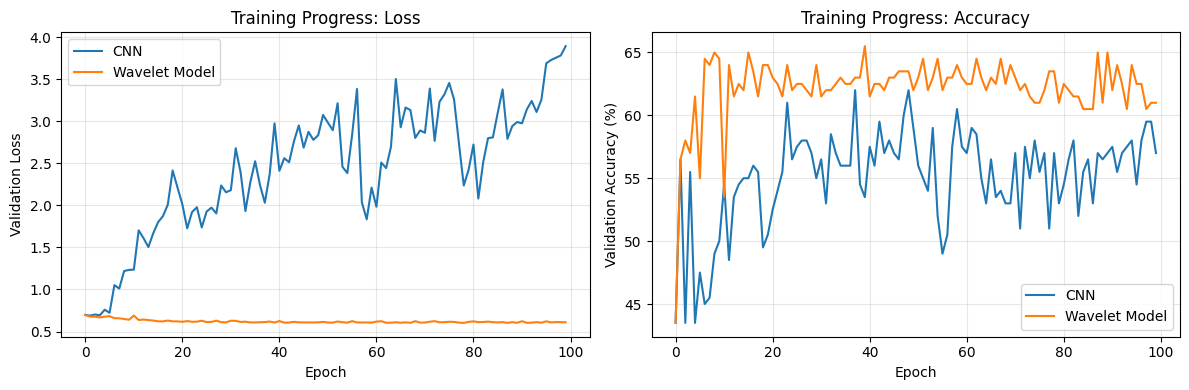

In [12]:
# Plot training curves
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Loss comparison
axes[0].plot(val_losses_cnn, label='CNN')
axes[0].plot(val_losses_wavelet, label='Wavelet Model')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Validation Loss')
axes[0].set_title('Training Progress: Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Accuracy comparison
axes[1].plot(val_accs_cnn, label='CNN')
axes[1].plot(val_accs_wavelet, label='Wavelet Model')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Validation Accuracy (%)')
axes[1].set_title('Training Progress: Accuracy')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 7. Performance vs Dataset Size

In [13]:
# ============================================================
# TEST: How does performance scale with dataset size?
# Key insight: Wavelet model needs less data due to inductive bias
# ============================================================
def train_and_evaluate(n_samples, epochs_short=25, seed=42):
    """Train both models on a dataset of given size and return accuracies."""
    train_loader, val_loader = create_dataloaders(n_samples=n_samples, snr=0.6, seed=seed)
    
    # Fresh models
    cnn = SimpleCNN(input_length=2560).to(device)
    wav = WaveletModel(duration=1.0, fs=256, f0=2, scale=0.1).to(device)
    
    opt_cnn = optim.Adam(cnn.parameters(), lr=0.001)
    opt_wav = optim.Adam(wav.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()
    
    # Train and track best
    best_cnn, best_wav = 0.0, 0.0
    for _ in range(epochs_short):
        train_epoch(cnn, train_loader, criterion, opt_cnn, device)
        _, acc = validate(cnn, val_loader, criterion, device)
        best_cnn = max(best_cnn, acc)
        
        train_epoch(wav, train_loader, criterion, opt_wav, device)
        _, acc = validate(wav, val_loader, criterion, device)
        best_wav = max(best_wav, acc)
    
    return best_cnn, best_wav

In [14]:
# Run dataset size experiment
dataset_sizes = [100, 300, 600, 1000, 3000, 6000, 10000]
cnn_accuracies, wavelet_accuracies = [], []

print("Testing different dataset sizes...")
for i, size in enumerate(dataset_sizes):
    print(f"  {size} samples...", end=" ")
    cnn_acc, wav_acc = train_and_evaluate(size, epochs_short=20, seed=42+i)
    cnn_accuracies.append(cnn_acc)
    wavelet_accuracies.append(wav_acc)
    print(f"CNN: {cnn_acc:.1f}%, Wavelet: {wav_acc:.1f}%")

Testing different dataset sizes...
  100 samples... CNN: 55.0%, Wavelet: 50.0%
  300 samples... CNN: 58.3%, Wavelet: 66.7%
  600 samples... CNN: 55.0%, Wavelet: 74.2%
  1000 samples... CNN: 52.5%, Wavelet: 62.0%
  3000 samples... CNN: 53.7%, Wavelet: 66.2%
  6000 samples... CNN: 50.8%, Wavelet: 66.7%
  10000 samples... CNN: 52.4%, Wavelet: 68.0%


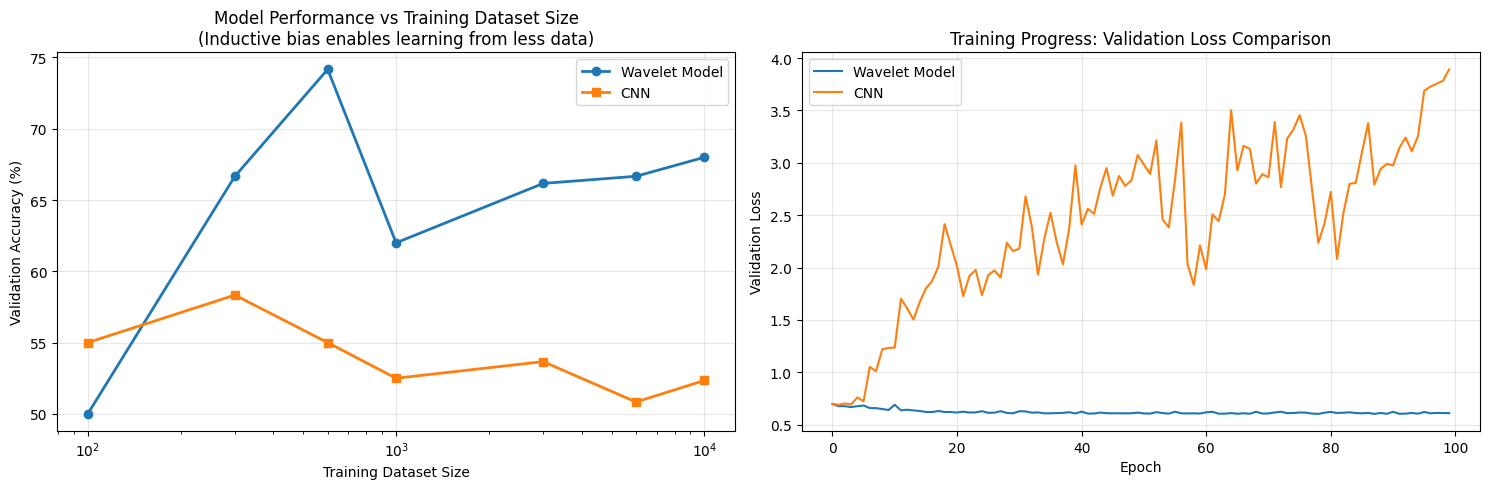

In [17]:
# Plot both comparisons side by side
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Left plot: Dataset size comparison
axes[0].plot(dataset_sizes, wavelet_accuracies, 'o-', linewidth=2, markersize=6, label='Wavelet Model')
axes[0].plot(dataset_sizes, cnn_accuracies, 's-', linewidth=2, markersize=6, label='CNN')
axes[0].set_xlabel('Training Dataset Size')
axes[0].set_ylabel('Validation Accuracy (%)')
axes[0].set_title('Model Performance vs Training Dataset Size\n(Inductive bias enables learning from less data)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].set_xscale('log')

# Right plot: Training progress comparison  
axes[1].plot(val_losses_wavelet, label='Wavelet Model')
axes[1].plot(val_losses_cnn, label='CNN')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Validation Loss')
axes[1].set_title('Training Progress: Validation Loss Comparison')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()